In [41]:
#imports for the project
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import time

from skforecast.ForecasterAutoreg import ForecasterAutoreg

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import xgboost as xgb

from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

from tabulate import tabulate

# **Wind Farm #1**

In [42]:
# Setting the path to the dataset folder
DATA_PATH = 'Datasets'

# Reading the Excel file containing data for Wind farm site 1 into a DataFrame
df_wf1 = pd.read_excel(
    os.path.join(DATA_PATH,'Wind farm site 1 (Nominal capacity-99MW).xlsx'), 
)

# Setting display option to show all columns when displaying the DataFrame
pd.set_option('display.max_columns', None)
df_wf1

,Time(year-month-day h:m:s),Wind speed at height of 10 meters (m/s),Wind direction at height of 10 meters (˚),Wind speed at height of 30 meters (m/s),Wind direction at height of 30 meters (˚),Wind speed at height of 50 meters (m/s),Wind direction at height of 50 meters (˚),Wind speed - at the height of wheel hub (m/s),Wind speed - at the height of wheel hub (˚),Air temperature (°C),Atmosphere (hpa),Relative humidity (%),Power (MW)
0,2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
1,2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2,2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306
3,2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590
4,2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70171,2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642
70172,2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759
70173,2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931
70174,2020-12-31 23:30:00,3.730,242.580,3.280,252.492,3.204,268.600,3.446,266.733,-9.633,889.492,54.677,7.185250


In [43]:
# Renaming the columns of the DataFrame df_wf1 for clarity and consistency
df_wf1.columns=['time','WS_10','WD_10','WS_30','WD_30','WS_50','WD_50','WS_cen','WD_cen','Air_T','Air_P','Air_H','Power(MW)']

# Stripping any leading or trailing whitespace from the column names of df_wf1
df_wf1.columns = [col.strip() for col in df_wf1.columns]

In [44]:
df_wf1.describe()

,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
count,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000
mean,5.711011,222.829748,6.039255,220.633957,6.168763,221.868203,6.375876,216.986224,8.543324,889.527469,37.581143,23.426896
std,3.119512,73.705902,3.700131,79.846922,3.874708,83.092270,3.907965,85.404564,13.368410,2.439019,18.896256,24.130181
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-24.131000,858.400000,1.502000,0.000000
25%,3.538000,209.431500,3.302000,192.871000,3.194000,169.800000,3.300000,144.067000,-3.271000,889.550000,22.355000,1.572839
50%,5.389000,235.987000,5.783000,245.442000,5.811000,251.833000,5.879500,248.825000,9.823000,889.742000,34.401500,14.957783
75%,7.217250,275.287000,8.091000,277.580250,8.384000,281.433000,8.604000,279.304250,19.756000,889.925000,51.584000,40.215230
max,25.465000,358.987000,29.187000,359.087000,29.678000,358.933000,30.247000,358.500000,36.130000,918.192000,93.120000,98.094440


In [45]:
# Filtering rows in DataFrame df_wf1 where the 'Power(MW)' column has a value of 0.0
df_wf1[df_wf1['Power(MW)'] == 0.0]

# Shows only around 200 / 70000 rows have zero power, mostly real values in the data

,time,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
39247,2020-02-13 19:45:00,3.378,125.700,4.118,111.548,4.456,114.367,4.631,110.267,-1.859,889.567,24.475,0.0
39248,2020-02-13 20:00:00,3.343,128.193,4.602,109.619,4.861,111.433,5.040,105.733,-2.201,890.200,25.381,0.0
39249,2020-02-13 20:15:00,3.448,142.987,4.513,115.724,4.681,116.833,4.736,110.300,-2.814,890.283,25.963,0.0
39250,2020-02-13 20:30:00,3.503,147.780,4.755,117.541,4.727,119.900,4.728,114.000,-2.753,889.583,25.968,0.0
39251,2020-02-13 20:45:00,3.656,139.320,4.862,111.267,5.121,112.900,5.258,108.533,-3.267,890.100,26.437,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57589,2020-08-22 21:15:00,6.288,266.327,7.827,264.050,8.048,268.900,8.369,266.983,22.202,889.400,23.480,0.0
57590,2020-08-22 21:30:00,6.451,260.760,7.705,262.396,8.150,267.700,8.494,264.900,21.460,889.717,24.067,0.0
57591,2020-08-22 21:45:00,5.180,258.653,6.334,259.231,6.924,265.633,7.119,260.400,21.502,889.567,24.744,0.0
57592,2020-08-22 22:00:00,5.211,241.840,6.157,245.209,6.550,253.367,6.766,248.783,21.014,889.550,25.536,0.0


In [46]:
# Displaying information about the DataFrame df_wf1, including the data types, number of non-null values, and memory usage
df_wf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70176 entries, 0 to 70175
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       70176 non-null  object 
 1   WS_10      70176 non-null  float64
 2   WD_10      70176 non-null  float64
 3   WS_30      70176 non-null  float64
 4   WD_30      70176 non-null  float64
 5   WS_50      70176 non-null  float64
 6   WD_50      70176 non-null  float64
 7   WS_cen     70176 non-null  float64
 8   WD_cen     70176 non-null  float64
 9   Air_T      70176 non-null  float64
 10  Air_P      70176 non-null  float64
 11  Air_H      70176 non-null  float64
 12  Power(MW)  70176 non-null  float64
dtypes: float64(12), object(1)
memory usage: 7.0+ MB


In [47]:
# Converting the 'time' column in DataFrame df_wf1 to datetime format using the specified format string '%Y-%m-%d %H:%M:%S'
df_wf1['time'] = pd.to_datetime(df_wf1['time'], format='%Y-%m-%d %H:%M:%S')

In [48]:
# Checking is there is any null data in the dataframe
df_wf1.isnull().mean()

time         0.0
WS_10        0.0
WD_10        0.0
WS_30        0.0
WD_30        0.0
WS_50        0.0
WD_50        0.0
WS_cen       0.0
WD_cen       0.0
Air_T        0.0
Air_P        0.0
Air_H        0.0
Power(MW)    0.0
dtype: float64

In [49]:
# DataFrame df_wf1
df_wf1

,time,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
0,2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
1,2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2,2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306
3,2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590
4,2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70171,2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642
70172,2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759
70173,2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931
70174,2020-12-31 23:30:00,3.730,242.580,3.280,252.492,3.204,268.600,3.446,266.733,-9.633,889.492,54.677,7.185250


Power(MW) column deals with 0.0 values, hence we will remove these rows to have realistic MAPE calculations.

## **Correlation matrix**

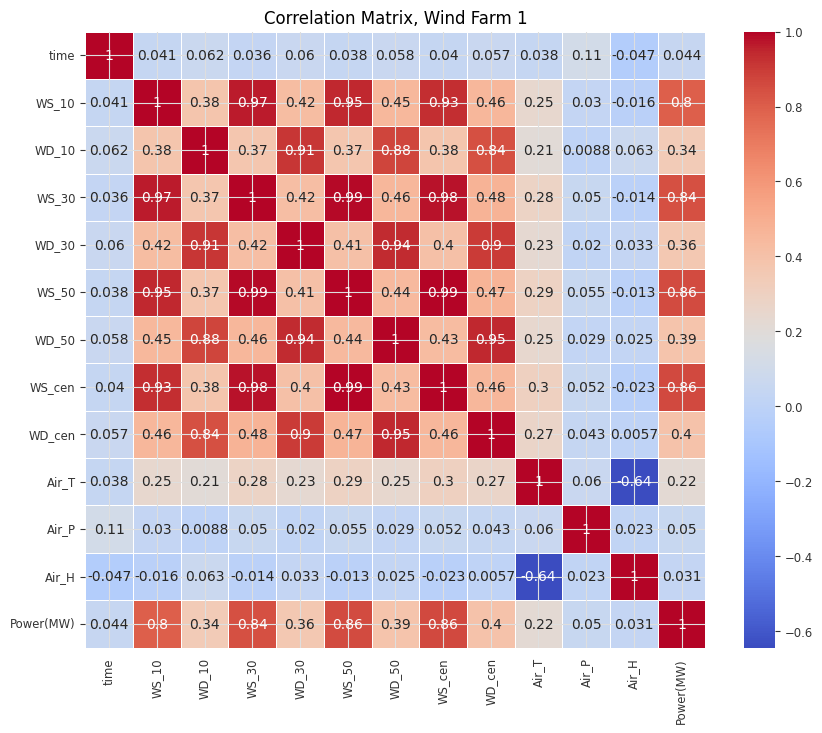

In [50]:
correlation_matrix = df_wf1.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix, Wind Farm 1')
plt.show()

## **Pairplots**

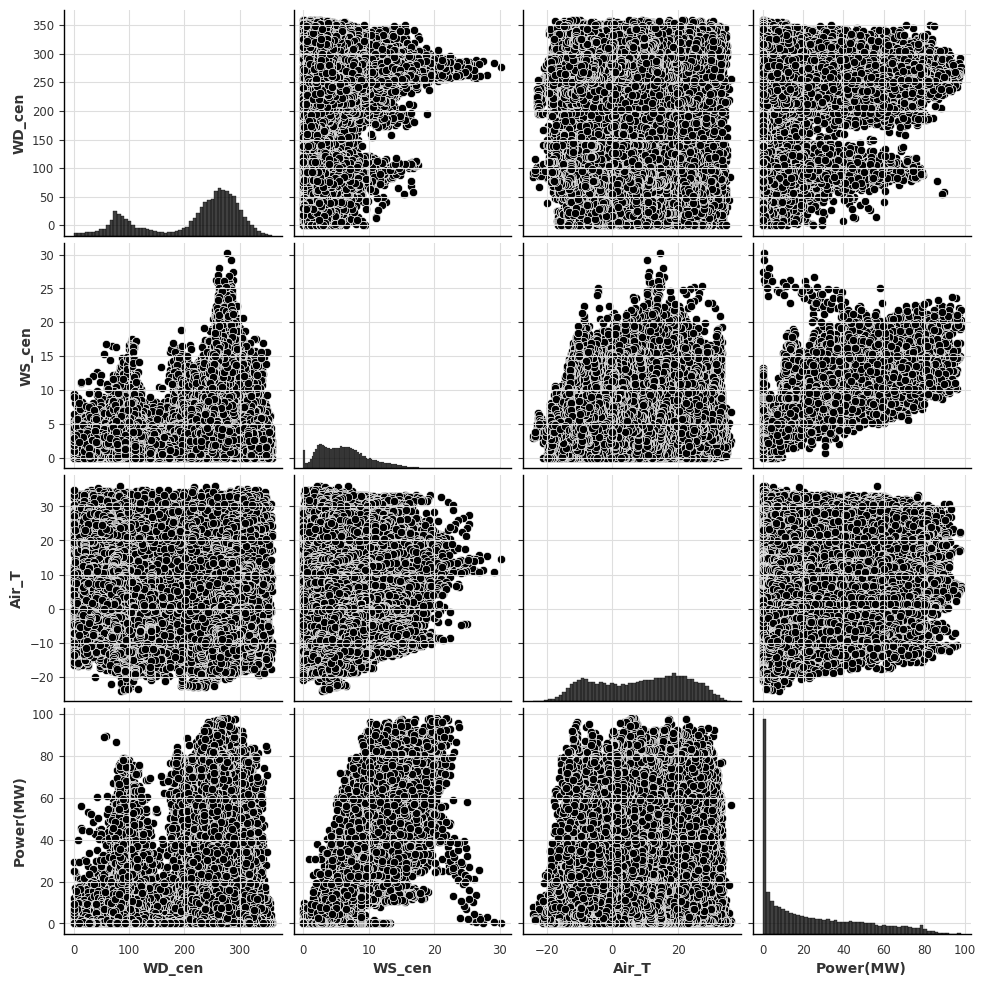

In [51]:
# Selecting the columns of interest
selected_columns = ['time', 'WD_cen', 'WS_cen', 'Air_T', 'Power(MW)']

# Creating a DataFrame with only the selected columns
df_selected = df_wf1[selected_columns]

# Plotting the pairplot
sns.pairplot(df_selected)
plt.show()

#### Engineering the WD_cen data

<Axes: xlabel='WD_cen', ylabel='Power(MW)'>

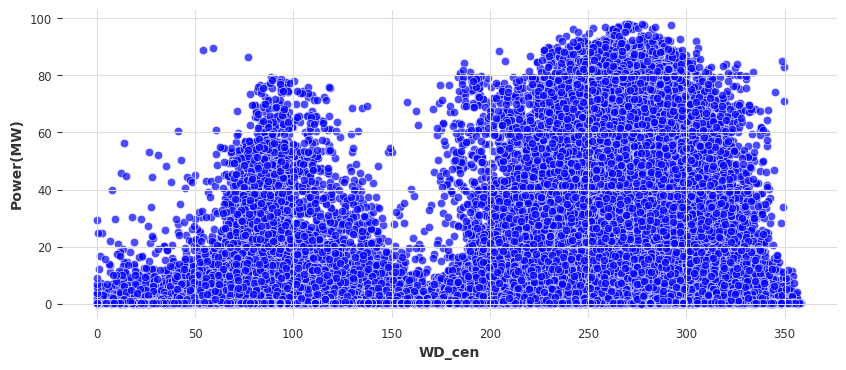

In [52]:
# Plotting
plt.figure(figsize=(10, 4))

# Scatter plot
sns.scatterplot(x='WD_cen', y='Power(MW)', data=df_wf1, color='blue', alpha=0.7)

This shows that the WD_cen correlated to power has a relation to the absolute sine of the angle. To better help correlation and the model, we can engineer a new column for WD_cen_sin to use in our model.

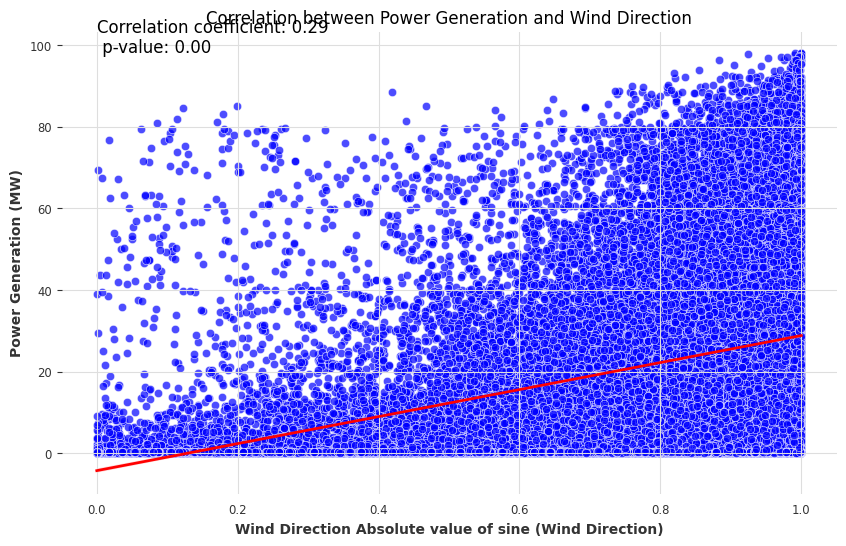

In [53]:
# Calculate the absolute value of sin(WD_cen)
df_wf1['WD_cen_sin'] = np.abs(np.sin(np.radians(df_wf1['WD_cen'])))

# Compute the Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(df_wf1['Power(MW)'], df_wf1['WD_cen_sin'])

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot
sns.scatterplot(x='WD_cen_sin', y='Power(MW)', data=df_wf1, color='blue', alpha=0.7)

# Adding the regression line
sns.regplot(x='WD_cen_sin', y='Power(MW)', data=df_wf1, scatter=False, color='red')

# Annotate the correlation coefficient and p-value
plt.text(df_wf1['WD_cen_sin'].min(), df_wf1['Power(MW)'].max(), f'Correlation coefficient: {correlation_coefficient:.2f}\n p-value: {p_value:.2f}', fontsize=12)

# Labels and title
plt.xlabel('Wind Direction Absolute value of sine (Wind Direction)')
plt.ylabel('Power Generation (MW)')
plt.title('Correlation between Power Generation and Wind Direction')

# Show plot
plt.grid(True)
plt.show()

In [54]:
# Calculating Pearson correlation coefficient and p-value for each pair
correlation_results = {
    'Variable': ['WS_10', 'WS_30', 'WS_50', 'WS_cen', 'WD_cen', 'Air_T'],
    'Pearson Correlation': [
        pearsonr(df_wf1['WS_10'], df_wf1['Power(MW)'])[0],
        pearsonr(df_wf1['WS_30'], df_wf1['Power(MW)'])[0],
        pearsonr(df_wf1['WS_50'], df_wf1['Power(MW)'])[0],
        pearsonr(df_wf1['WS_cen'], df_wf1['Power(MW)'])[0],
        pearsonr(df_wf1['WD_cen'], df_wf1['Power(MW)'])[0],
        pearsonr(df_wf1['Air_T'], df_wf1['Power(MW)'])[0]
    ],
    'p-value': [
        pearsonr(df_wf1['WS_10'], df_wf1['Power(MW)'])[1],
        pearsonr(df_wf1['WS_30'], df_wf1['Power(MW)'])[1],
        pearsonr(df_wf1['WS_50'], df_wf1['Power(MW)'])[1],
        pearsonr(df_wf1['WS_cen'], df_wf1['Power(MW)'])[1],
        pearsonr(df_wf1['WD_cen'], df_wf1['Power(MW)'])[1],
        pearsonr(df_wf1['Air_T'], df_wf1['Power(MW)'])[1]
    ]
}

# Creating a DataFrame from the correlation results
correlation_df = pd.DataFrame(correlation_results)

# Displaying the correlation results as a table
print(correlation_df)

  Variable  Pearson Correlation  p-value
0    WS_10             0.799860      0.0
1    WS_30             0.839959      0.0
2    WS_50             0.856314      0.0
3   WS_cen             0.861730      0.0
4   WD_cen             0.396059      0.0
5    Air_T             0.216716      0.0


With respect to the target variable [Power (MW)], the 4 below features have high correlations on top of very significant pvalues:
- 0.8 with Wind speed at height of 10 meters (m/s)
- 0.84 with Wind speed at height of 30 meters (m/s)
- 0.86 with Wind speed at height of 50 meters (m/s)
- 0.86 with Wind speed - at the height of wheel hub (m/s)

In [55]:
# Setting the 'time' column as the index of DataFrame df_wf1, making it the new index for the DataFrame
df_wf1.set_index('time', inplace=True)
df_wf1

,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW),WD_cen_sin
time,,,,,,,,,,,,,
2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383,0.963630
2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703,0.963008
2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306,0.999848
2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590,0.991967
2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005,0.998660
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642,0.852029
2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759,0.837080
2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931,0.989609


In [56]:
# Resampling DataFrame df_wf1 to a frequency of 15 minutes ('15min'), filling any missing values with NaN
df_wf1 = df_wf1.asfreq('15min')
print(df_wf1.index.freq)

<15 * Minutes>


In [57]:
"""

#Creating lag values of Power
df_wf1['Power(MW)_lag_1'] = df_wf1['Power(MW)'].shift(1)

#Dropping the first row because of NaN created by applying lag values to Power
df_wf1 = df_wf1.iloc[1:]

"""

"\n\n#Creating lag values of Power\ndf_wf1['Power(MW)_lag_1'] = df_wf1['Power(MW)'].shift(1)\n\n#Dropping the first row because of NaN created by applying lag values to Power\ndf_wf1 = df_wf1.iloc[1:]\n\n"

## **Preparing training, testing and demo datasets**

We will slip the entire .csv file into three subdatasets:

- **Modeling**
1. Training (to input training data into forecasting models)
2. Testing (to test forecasting models comparing forcasting with testing data)

- **Demo**
3. Historical (to refit the training+testing with real data after each user forecast request; 1 month of data)

In [58]:
one_month_range = df_wf1.index.max() - pd.DateOffset(months=1)

# Create a DataFrame df_demo containing data from the last month of data in the dataset
df_demo = df_wf1[df_wf1.index >= one_month_range]

# Create a DataFrame df_wf1_model containing data up to one month before the maximum timestamp
df_wf1_model = df_wf1[df_wf1.index < one_month_range]

# Split the training set into quarters
df_wf1_first_50, df_wf1_last_50 = train_test_split(df_wf1_model, train_size = 0.5, test_size = 0.5, shuffle=False)

df_wf1_first_25, df_wf1_second_25 = train_test_split(df_wf1_first_50, train_size = 0.5, test_size = 0.5, shuffle=False)
df_wf1_third_25, df_wf1_fourth_25 = train_test_split(df_wf1_last_50, train_size = 0.5, test_size = 0.5, shuffle=False)

# Split each quarter into training and testing sets, with a train size of 98% and a test size of 2%
df_wf1_1_train, df_wf1_1_test = train_test_split(df_wf1_first_25, train_size = 0.995, test_size = 0.005, shuffle=False)
df_wf1_2_train, df_wf1_2_test = train_test_split(df_wf1_second_25, train_size = 0.995, test_size = 0.005, shuffle=False)
df_wf1_3_train, df_wf1_3_test = train_test_split(df_wf1_third_25, train_size = 0.995, test_size = 0.005, shuffle=False)
df_wf1_4_train, df_wf1_4_test = train_test_split(df_wf1_fourth_25, train_size = 0.995, test_size = 0.005, shuffle=False)

In [59]:
features_to_test=['WS_cen', 'WD_cen_sin', 'Air_T']

# Creating training sets for each quarter of the dataset
y_train_1 = df_wf1_1_train[['Power(MW)']]
X_train_1 = df_wf1_1_train[features_to_test]

y_train_2 = df_wf1_2_train[['Power(MW)']]
X_train_2 = df_wf1_2_train[features_to_test]

y_train_3 = df_wf1_3_train[['Power(MW)']]
X_train_3 = df_wf1_3_train[features_to_test]

y_train_4 = df_wf1_4_train[['Power(MW)']]
X_train_4 = df_wf1_4_train[features_to_test]

# Creating a list of tuples containing each training set (target variable and features)
train_datasets = [(y_train_1, X_train_1), (y_train_2, X_train_2), (y_train_3, X_train_3), (y_train_4, X_train_4)]

In [60]:
# Creating test sets for each quarter of the dataset
y_test_1 = df_wf1_1_test[['Power(MW)']]
X_test_1 = df_wf1_1_test[features_to_test]

y_test_2 = df_wf1_2_test[['Power(MW)']]
X_test_2 = df_wf1_2_test[features_to_test]

y_test_3 = df_wf1_3_test[['Power(MW)']]
X_test_3 = df_wf1_3_test[features_to_test]

y_test_4 = df_wf1_4_test[['Power(MW)']]
X_test_4 = df_wf1_4_test[features_to_test]

# Creating a list of tuples containing each test set (target variable and features)
test_datasets = [(y_test_1, X_test_1), (y_test_2, X_test_2), (y_test_3, X_test_3), (y_test_4, X_test_4)]

In [61]:
print(df_wf1.index.freq)

<15 * Minutes>


In [62]:
y_train_1

,Power(MW)
time,
2019-01-01 00:00:00,0.254383
2019-01-01 00:15:00,0.329703
2019-01-01 00:30:00,0.296306
2019-01-01 00:45:00,0.187590
2019-01-01 01:00:00,0.081005
...,...
2019-06-24 01:30:00,32.029503
2019-06-24 01:45:00,32.427420
2019-06-24 02:00:00,34.294790


## **Naïve forecaster model**

In [63]:
start_time = time.time()

naive_predictions_dict = {}

for i, (y_train, _) in enumerate(train_datasets, 1):
    y_test, _ = test_datasets[i - 1]

    forecast_naive = NaiveForecaster(strategy="mean")
    forecasted_naive = forecast_naive.fit(y_train)

    forecast_horizon = ForecastingHorizon([i for i in range(1, len(y_test) + 1)])

    predictions_naive = forecasted_naive.predict(fh=forecast_horizon)

    naive_predictions_dict[f'predictions_{i}'] = predictions_naive

y_pred_naive_1 = naive_predictions_dict['predictions_1']
y_pred_naive_2 = naive_predictions_dict['predictions_2']
y_pred_naive_3 = naive_predictions_dict['predictions_3']
y_pred_naive_4 = naive_predictions_dict['predictions_4']

end_time = time.time()
naiveTime = end_time - start_time

## **Linear regression model**

In [64]:
"""
start_time = time.time()

linear_predictions_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    _, X_test = test_datasets[i - 1]

    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    
    predictions_linear = linear_model.predict(X_test)
    predictions_linear_df = pd.DataFrame(predictions_linear, index=X_test.index, columns=['Predicted Power(MW)'])

    linear_predictions_dict[f'predictions_{i}'] = predictions_linear_df

y_pred_linear_1 = linear_predictions_dict['predictions_1']
y_pred_linear_2 = linear_predictions_dict['predictions_2']
y_pred_linear_3 = linear_predictions_dict['predictions_3']
y_pred_linear_4 = linear_predictions_dict['predictions_4']

end_time = time.time()
linearTime = end_time - start_time
"""

"\nstart_time = time.time()\n\nlinear_predictions_dict = {}\n\nfor i, (y_train, X_train) in enumerate(train_datasets, 1):\n    _, X_test = test_datasets[i - 1]\n\n    linear_model = LinearRegression()\n    linear_model.fit(X_train, y_train)\n    \n    predictions_linear = linear_model.predict(X_test)\n    predictions_linear_df = pd.DataFrame(predictions_linear, index=X_test.index, columns=['Predicted Power(MW)'])\n\n    linear_predictions_dict[f'predictions_{i}'] = predictions_linear_df\n\ny_pred_linear_1 = linear_predictions_dict['predictions_1']\ny_pred_linear_2 = linear_predictions_dict['predictions_2']\ny_pred_linear_3 = linear_predictions_dict['predictions_3']\ny_pred_linear_4 = linear_predictions_dict['predictions_4']\n\nend_time = time.time()\nlinearTime = end_time - start_time\n"

In [100]:
from darts import TimeSeries
from darts.models import RegressionModel
from sklearn.linear_model import LinearRegression

start_time = time.time()

linear_predictions_dict = {}

for i, (y_train, _) in enumerate(train_datasets, 1):
    y_test, _ = test_datasets[i - 1]

    model = RegressionModel(lags=[-1, -2, -3], model=LinearRegression())
    y_train_series = TimeSeries.from_dataframe(y_train, value_cols=['Power(MW)'])

    model.fit(series=y_train_series)
    predictions_linear_df = model.predict(n=len(y_test), series=y_train_series)

    linear_predictions_dict[f'predictions_{i}'] = predictions_linear_df

y_pred_linear_1 = linear_predictions_dict['predictions_1']
y_pred_linear_2 = linear_predictions_dict['predictions_2']
y_pred_linear_3 = linear_predictions_dict['predictions_3']
y_pred_linear_4 = linear_predictions_dict['predictions_4']

end_time = time.time()
linearTime = end_time - start_time

In [94]:
y_test

,Power(MW)
time,
2020-11-30 02:45:00,0.238040
2020-11-30 03:00:00,0.231645
2020-11-30 03:15:00,0.583375
2020-11-30 03:30:00,1.609433
2020-11-30 03:45:00,3.061832
...,...
2020-11-30 22:30:00,10.851063
2020-11-30 22:45:00,10.628656
2020-11-30 23:00:00,9.255841


In [88]:
y_pred_linear_1

<TimeSeries (DataArray) (time: 84, component: 1, sample: 1)> Size: 672B
array([[[43.72080214]],

       [[42.90081691]],

       [[42.15687711]],

       [[41.62583011]],

       [[41.16026415]],

       [[40.69978153]],

       [[40.2432257 ]],

       [[39.7970352 ]],

       [[39.36301678]],

       [[38.94071031]],

...

       [[26.04839568]],

       [[25.97531696]],

       [[25.90415499]],

       [[25.83485947]],

       [[25.76738147]],

       [[25.70167331]],

       [[25.63768857]],

       [[25.57538205]],

       [[25.51470973]],

       [[25.45562874]]])
Coordinates:
  * time       (time) datetime64[ns] 672B 2019-06-24T02:45:00 ... 2019-06-24T...
  * component  (component) object 8B 'Power(MW)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [78]:
y_test

,Power(MW)
time,
2020-11-30 02:45:00,0.238040
2020-11-30 03:00:00,0.231645
2020-11-30 03:15:00,0.583375
2020-11-30 03:30:00,1.609433
2020-11-30 03:45:00,3.061832
...,...
2020-11-30 22:30:00,10.851063
2020-11-30 22:45:00,10.628656
2020-11-30 23:00:00,9.255841


In [76]:
y_pred_linear_1

<TimeSeries (DataArray) (time: 84, component: 1, sample: 1)> Size: 672B
array([[[43.72080214]],

       [[42.90081691]],

       [[42.15687711]],

       [[41.62583011]],

       [[41.16026415]],

       [[40.69978153]],

       [[40.2432257 ]],

       [[39.7970352 ]],

       [[39.36301678]],

       [[38.94071031]],

...

       [[26.04839568]],

       [[25.97531696]],

       [[25.90415499]],

       [[25.83485947]],

       [[25.76738147]],

       [[25.70167331]],

       [[25.63768857]],

       [[25.57538205]],

       [[25.51470973]],

       [[25.45562874]]])
Coordinates:
  * time       (time) datetime64[ns] 672B 2019-06-24T02:45:00 ... 2019-06-24T...
  * component  (component) object 8B 'Power(MW)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [66]:
"""
start_time = time.time()

linear_predictions_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_train_power = y_train['Power(MW)']
    y_test, _ = test_datasets[i - 1]
    
    forecaster = ForecasterAutoreg(regressor=LinearRegression(), lags=3)
    
    forecaster.fit(y=y_train_power)
    
    y_pred_series = pd.Series(forecaster.predict(steps=len(y_test)), index=y_test.index)
    
    predictions_linear_df = pd.DataFrame({'Predicted Power(MW)': y_pred_series})
    
    linear_predictions_dict[f'predictions_{i}'] = predictions_linear_df

y_pred_linear_1 = linear_predictions_dict['predictions_1']
y_pred_linear_2 = linear_predictions_dict['predictions_2']
y_pred_linear_3 = linear_predictions_dict['predictions_3']
y_pred_linear_4 = linear_predictions_dict['predictions_4']

end_time = time.time()
linearTime = end_time - start_time
"""

"\nstart_time = time.time()\n\nlinear_predictions_dict = {}\n\nfor i, (y_train, X_train) in enumerate(train_datasets, 1):\n    y_train_power = y_train['Power(MW)']\n    y_test, _ = test_datasets[i - 1]\n    \n    forecaster = ForecasterAutoreg(regressor=LinearRegression(), lags=3)\n    \n    forecaster.fit(y=y_train_power)\n    \n    y_pred_series = pd.Series(forecaster.predict(steps=len(y_test)), index=y_test.index)\n    \n    predictions_linear_df = pd.DataFrame({'Predicted Power(MW)': y_pred_series})\n    \n    linear_predictions_dict[f'predictions_{i}'] = predictions_linear_df\n\ny_pred_linear_1 = linear_predictions_dict['predictions_1']\ny_pred_linear_2 = linear_predictions_dict['predictions_2']\ny_pred_linear_3 = linear_predictions_dict['predictions_3']\ny_pred_linear_4 = linear_predictions_dict['predictions_4']\n\nend_time = time.time()\nlinearTime = end_time - start_time\n"

## **LSTM - Long short-term memory model**

In [67]:
"""
start_time = time.time()

def train_and_forecast_lstm(X_train, y_train, X_test):
    X_train_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_lstm = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

    model_lstm = Sequential()
    model_lstm.add(LSTM(units=85, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model_lstm.add(Dense(units=1))
    model_lstm.compile(optimizer='adam', loss='mean_squared_error')

    model_lstm.fit(X_train_lstm, y_train, epochs=80, batch_size=50, verbose=0)

    predictions = model_lstm.predict(X_test_lstm)
    predictions_lstm = pd.DataFrame(predictions, index=X_test.index, columns=['Predicted Power(MW)'])

    return predictions_lstm

predictions_lstm_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test, X_test = test_datasets[i - 1]
    
    predictions_lstm = train_and_forecast_lstm(X_train, y_train, X_test)
    
    predictions_lstm_dict[f'predictions_{i}'] = predictions_lstm

y_pred_lstm_1 = predictions_lstm_dict['predictions_1']
y_pred_lstm_2 = predictions_lstm_dict['predictions_2']
y_pred_lstm_3 = predictions_lstm_dict['predictions_3']
y_pred_lstm_4 = predictions_lstm_dict['predictions_4']

end_time = time.time()
lstmTime = end_time - start_time
"""

"\nstart_time = time.time()\n\ndef train_and_forecast_lstm(X_train, y_train, X_test):\n    X_train_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])\n    X_test_lstm = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])\n\n    model_lstm = Sequential()\n    model_lstm.add(LSTM(units=85, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))\n    model_lstm.add(Dense(units=1))\n    model_lstm.compile(optimizer='adam', loss='mean_squared_error')\n\n    model_lstm.fit(X_train_lstm, y_train, epochs=80, batch_size=50, verbose=0)\n\n    predictions = model_lstm.predict(X_test_lstm)\n    predictions_lstm = pd.DataFrame(predictions, index=X_test.index, columns=['Predicted Power(MW)'])\n\n    return predictions_lstm\n\npredictions_lstm_dict = {}\n\nfor i, (y_train, X_train) in enumerate(train_datasets, 1):\n    y_test, X_test = test_datasets[i - 1]\n    \n    predictions_lstm = train_and_forecast_lstm(X_train, y_train, X_test)\n    \n    predictions_lstm_dict[f'p

Without X_test

In [68]:
start_time = time.time()

predictions_lstm_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test, X_test = test_datasets[i - 1]

    X_train_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_lstm = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

    model_lstm = Sequential()
    model_lstm.add(LSTM(units=85, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model_lstm.add(Dense(units=1))
    model_lstm.compile(optimizer='adam', loss='mean_squared_error')

    model_lstm.fit(X_train_lstm, y_train, epochs=80, batch_size=50, verbose=0)

    predictions = []

    for _ in range(len(X_test)):
        y_pred = model_lstm.predict(X_test_lstm[:1])
        predictions.append(y_pred[0][0])
        X_test_lstm = np.roll(X_test_lstm, -1, axis=0)
        X_test_lstm[-1] = y_pred

    predictions_lstm = pd.DataFrame(predictions, index=X_test.index, columns=['Predicted Power(MW)'])

    predictions_lstm_dict[f'predictions_{i}'] = predictions_lstm

y_pred_lstm_1 = predictions_lstm_dict['predictions_1']
y_pred_lstm_2 = predictions_lstm_dict['predictions_2']
y_pred_lstm_3 = predictions_lstm_dict['predictions_3']
y_pred_lstm_4 = predictions_lstm_dict['predictions_4']

end_time = time.time()
lstmTime = end_time - start_time

C:\Users\mattd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━

## **Random Forest model**

In [69]:
start_time = time.time()

predictions_randomforest_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_train_power = y_train['Power(MW)']
    y_test, _ = test_datasets[i - 1]
    
    forecaster = ForecasterAutoreg(regressor=RandomForestRegressor(bootstrap=True, n_estimators=800, random_state=42), lags=3)
    
    forecaster.fit(y=y_train_power)
    
    y_pred_series = pd.Series(forecaster.predict(steps=len(y_test)), index=y_test.index)
    
    predictions_randomforest = pd.DataFrame({'Predicted Power(MW)': y_pred_series})
    
    predictions_randomforest_dict[f'predictions_{i}'] = predictions_randomforest

y_pred_randomforest_1 = predictions_randomforest_dict['predictions_1']
y_pred_randomforest_2 = predictions_randomforest_dict['predictions_2']
y_pred_randomforest_3 = predictions_randomforest_dict['predictions_3']
y_pred_randomforest_4 = predictions_randomforest_dict['predictions_4']

end_time = time.time()
randomforestTime = end_time - start_time

## **XGBoost model**

In [70]:
start_time = time.time()

predictions_xgboost_dict = {}

xgboost_model = xgb.XGBRegressor(max_depth=3, learning_rate=0.11, n_estimators=62)

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_train_power = y_train['Power(MW)']
    y_test, _ = test_datasets[i - 1]
    
    forecaster = ForecasterAutoreg(regressor=xgb.XGBRegressor(max_depth=3, learning_rate=0.11, n_estimators=62), lags=3)
    
    forecaster.fit(y=y_train_power)
    
    y_pred_series = pd.Series(forecaster.predict(steps=len(y_test)), index=y_test.index)
    
    predictions_xgboost = pd.DataFrame({'Predicted Power(MW)': y_pred_series})
    
    predictions_xgboost_dict[f'predictions_{i}'] = predictions_xgboost

y_pred_xgboost_1 = predictions_xgboost_dict['predictions_1']
y_pred_xgboost_2 = predictions_xgboost_dict['predictions_2']
y_pred_xgboost_3 = predictions_xgboost_dict['predictions_3']
y_pred_xgboost_4 = predictions_xgboost_dict['predictions_4']

end_time = time.time()
xgboostTime = end_time - start_time

## **Reduction XGBoost model**

In [71]:
start_time = time.time()

predictions_reduction_xgboost_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test, X_test = test_datasets[i - 1]
    
    forecaster = make_reduction(xgboost_model, window_length=6, strategy='recursive', windows_identical=False)
    
    forecaster.fit(y_train)
    
    forecast_xgboost = []
    
    for t in range(len(y_test)):
 
        y_pred = forecaster.predict(fh=1)
        forecast_xgboost.append(y_pred.iloc[0])
        forecaster.update(y_test.iloc[t:t+1])
    
    predictions_reduction_xgboost_dict[f'predictions_{i}'] = pd.Series(forecast_xgboost, index=y_test.index)

y_pred_reduction_xgboost_1 = predictions_reduction_xgboost_dict['predictions_1']
y_pred_reduction_xgboost_2 = predictions_reduction_xgboost_dict['predictions_2']
y_pred_reduction_xgboost_3 = predictions_reduction_xgboost_dict['predictions_3']
y_pred_reduction_xgboost_4 = predictions_reduction_xgboost_dict['predictions_4']

end_time = time.time()
xgboostreductionTime = end_time - start_time

#downsampling to 30 minutes

C:\Users\mattd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sktime\forecasting\base\_base.py:2051: UserWarning: NotImplementedWarning: RecursiveTabularRegressionForecaster does not have a custom `update` method implemented. RecursiveTabularRegressionForecaster will be refit each time `update` is called with update_params=True. To refit less often, use the wrappers in the forecasting.stream module, e.g., UpdateEvery.
  warn(
C:\Users\mattd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sktime\forecasting\base\_base.py:2051: UserWarning: NotImplementedWarning: RecursiveTabularRegressionForecaster does not have a custom `update` method implemented. RecursiveTabularRegressionForecaster will be refit each time `update` is called with update_params=True. To refit less often, use the wrappers in the forecasting.stream module, e.g., UpdateE

## **ARIMA model**

In [72]:
start_time = time.time()

predictions_arima_dict = {}

# Iterate over each quarter's dataset
for i, (train_data, test_data) in enumerate(zip(train_datasets, test_datasets), start=1):
    print(f"Quarter {i}:")
    y_train, _ = train_data
    y_test, _ = test_data
    
    # Fit ARIMA model
    model = ARIMA(y_train, order=(1, 1, 1))  # Adjust order as needed
    model_fit = model.fit()

    # Make predictions
    forecast = model_fit.forecast(steps=len(y_test))[0]

    # Store predictions in the dictionary
    predictions_arima_dict[f'predictions_{i}'] = pd.Series(forecast, index=y_test.index)

# Accessing the predictions for each fold
y_pred_arima_1 = predictions_arima_dict['predictions_1']
y_pred_arima_2 = predictions_arima_dict['predictions_2']
y_pred_arima_3 = predictions_arima_dict['predictions_3']
y_pred_arima_4 = predictions_arima_dict['predictions_4']

end_time = time.time()
arimaTime = end_time - start_time

## **SARIMA model**

In [73]:
start_time = time.time()

predictions_sarima_dict = {}

for i, (y_train) in enumerate(train_datasets, 1):
    y_train_values = y_train[0].values
    y_test = test_datasets[i - 1][0]
    
    forecast_sarima = []
    actual_values = []

    model = SARIMAX(y_train_values, order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))
    model_fit = model.fit()

    for t in range(len(y_test)):
        output = model_fit.forecast(steps=1)
        forecast_sarima.append(output[0])
        
        actual_values.append(y_test.iloc[t])
        model_fit = model_fit.append([actual_values[-1]])

    predictions_sarima_dict[f'predictions_{i}'] = pd.Series(forecast_sarima, index=y_test.index)

y_pred_sarima_1 = predictions_sarima_dict['predictions_1']
y_pred_sarima_2 = predictions_sarima_dict['predictions_2']
y_pred_sarima_3 = predictions_sarima_dict['predictions_3']
y_pred_sarima_4 = predictions_sarima_dict['predictions_4']

end_time = time.time()
sarimaTime = end_time - start_time

## **Summary**

In [75]:
mae_naive_1 = mean_absolute_error(y_test_1, y_pred_naive_1)
mae_naive_2 = mean_absolute_error(y_test_2, y_pred_naive_2)
mae_naive_3 = mean_absolute_error(y_test_3, y_pred_naive_3)
mae_naive_4 = mean_absolute_error(y_test_4, y_pred_naive_4)
average_mae_naive = (mae_naive_1 + mae_naive_2 + mae_naive_3 + mae_naive_4) / 4

mae_linear_1 = mean_absolute_error(y_test_1, y_pred_linear_1)
mae_linear_2 = mean_absolute_error(y_test_2, y_pred_linear_2)
mae_linear_3 = mean_absolute_error(y_test_3, y_pred_linear_3)
mae_linear_4 = mean_absolute_error(y_test_4, y_pred_linear_4)
average_mae_linear = (mae_linear_1 + mae_linear_2 + mae_linear_3 + mae_linear_4) / 4

mae_lstm_1 = mean_absolute_error(y_test_1, y_pred_lstm_1)
mae_lstm_2 = mean_absolute_error(y_test_2, y_pred_lstm_2)
mae_lstm_3 = mean_absolute_error(y_test_3, y_pred_lstm_3)
mae_lstm_4 = mean_absolute_error(y_test_4, y_pred_lstm_4)
average_mae_lstm = (mae_lstm_1 + mae_lstm_2 + mae_lstm_3 + mae_lstm_4) / 4

mae_randomforest_1 = mean_absolute_error(y_test_1, y_pred_randomforest_1)
mae_randomforest_2 = mean_absolute_error(y_test_2, y_pred_randomforest_2)
mae_randomforest_3 = mean_absolute_error(y_test_3, y_pred_randomforest_3)
mae_randomforest_4 = mean_absolute_error(y_test_4, y_pred_randomforest_4)
average_mae_randomforest = (mae_randomforest_1 + mae_randomforest_2 + mae_randomforest_3 + mae_randomforest_4) / 4

mae_xgboost_1 = mean_absolute_error(y_test_1, y_pred_xgboost_1)
mae_xgboost_2 = mean_absolute_error(y_test_2, y_pred_xgboost_2)
mae_xgboost_3 = mean_absolute_error(y_test_3, y_pred_xgboost_3)
mae_xgboost_4 = mean_absolute_error(y_test_4, y_pred_xgboost_4)
average_mae_xgboost = (mae_xgboost_1 + mae_xgboost_2 + mae_xgboost_3 + mae_xgboost_4) / 4

mae_reduction_xgboost_1 = mean_absolute_error(y_test_1, y_pred_reduction_xgboost_1)
mae_reduction_xgboost_2 = mean_absolute_error(y_test_2, y_pred_reduction_xgboost_2)
mae_reduction_xgboost_3 = mean_absolute_error(y_test_3, y_pred_reduction_xgboost_3)
mae_reduction_xgboost_4 = mean_absolute_error(y_test_4, y_pred_reduction_xgboost_4)
average_mae_reduction_xgboost = (mae_reduction_xgboost_1 + mae_reduction_xgboost_2 + mae_reduction_xgboost_3 + mae_reduction_xgboost_4) / 4

mae_arima_1 = mean_absolute_error(y_test_1, y_pred_arima_1)
mae_arima_2 = mean_absolute_error(y_test_2, y_pred_arima_2)
mae_arima_3 = mean_absolute_error(y_test_3, y_pred_arima_3)
mae_arima_4 = mean_absolute_error(y_test_4, y_pred_arima_4)
average_mae_arima = (mae_arima_1 + mae_arima_2 + mae_arima_3 + mae_arima_4) / 4

mae_sarima_1 = mean_absolute_error(y_test_1, y_pred_sarima_1)
mae_sarima_2 = mean_absolute_error(y_test_2, y_pred_sarima_2)
mae_sarima_3 = mean_absolute_error(y_test_3, y_pred_sarima_3)
mae_sarima_4 = mean_absolute_error(y_test_4, y_pred_sarima_4)
average_mae_sarima = (mae_sarima_1 + mae_sarima_2 + mae_sarima_3 + mae_sarima_4) / 4

ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 32.

In [ ]:
models = [
    "Naive Forecaster",
    "Linear Regression",
    "LSTM (epochs=80, batch_size=50)", 
    "Random Forest (n_estimators=100, random_state=42)", 
    "XGBoost (max_depth=3, learning_rate=0.11, n_estimators=62)",
    "Reduction + XGBoost (window_length=5)",
    "ARIMA(1, 1, 1)",
    "SARIMA(1, 1, 1, 4)"
]

maes = [
    [mae_naive_1, mae_naive_2, mae_naive_3, mae_naive_4, average_mae_naive],
    [mae_linear_1, mae_linear_2, mae_linear_3, mae_linear_4, average_mae_linear],
    [mae_lstm_1, mae_lstm_2, mae_lstm_3, mae_lstm_4, average_mae_lstm],
    [mae_randomforest_1, mae_randomforest_2, mae_randomforest_3, mae_randomforest_4, average_mae_randomforest],
    [mae_xgboost_1, mae_xgboost_2, mae_xgboost_3, mae_xgboost_4, average_mae_xgboost],
    [mae_reduction_xgboost_1, mae_reduction_xgboost_2, mae_reduction_xgboost_3, mae_reduction_xgboost_4, average_mae_reduction_xgboost],
    [mae_arima_1, mae_arima_2, mae_arima_3, mae_arima_4, average_mae_arima],
    [mae_sarima_1, mae_sarima_2, mae_sarima_3, mae_sarima_4, average_mae_sarima]
]

run_times = [
    [naiveTime],
    [linearTime],
    [lstmTime],
    [randomforestTime],
    [xgboostTime],
    [xgboostreductionTime],
    [arimaTime],
    [sarimaTime]
]

headers = ["Model", "MAE 1", "MAE 2", "MAE 3", "MAE 4", "Average MAE", "RunTimes"]
table_data = []

for model, mae_list, times in zip(models, maes, run_times):
    table_data.append([model] + mae_list + times)

print(tabulate(table_data, headers=headers, tablefmt="grid"))

+------------------------------------------------------------+----------+----------+----------+----------+---------------+------------+
| Model                                                      |    MAE 1 |    MAE 2 |    MAE 3 |    MAE 4 |   Average MAE |   RunTimes |
+============================================================+==========+==========+==========+==========+===============+============+
| Naive Forecaster                                           | 34.9     | 39.2617  | 11.5144  | 16.8411  |      25.6293  |   0.149313 |
+------------------------------------------------------------+----------+----------+----------+----------+---------------+------------+
| Linear Regression                                          | 26.9472  | 20.8684  | 11.6063  |  8.85569 |      17.0694  |   0.137437 |
+------------------------------------------------------------+----------+----------+----------+----------+---------------+------------+
| LSTM (epochs=80, batch_size=50)               

C:\Users\mattd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
C:\Users\mattd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


ValueError: num must be an integer with 1 <= num <= 32, not 33

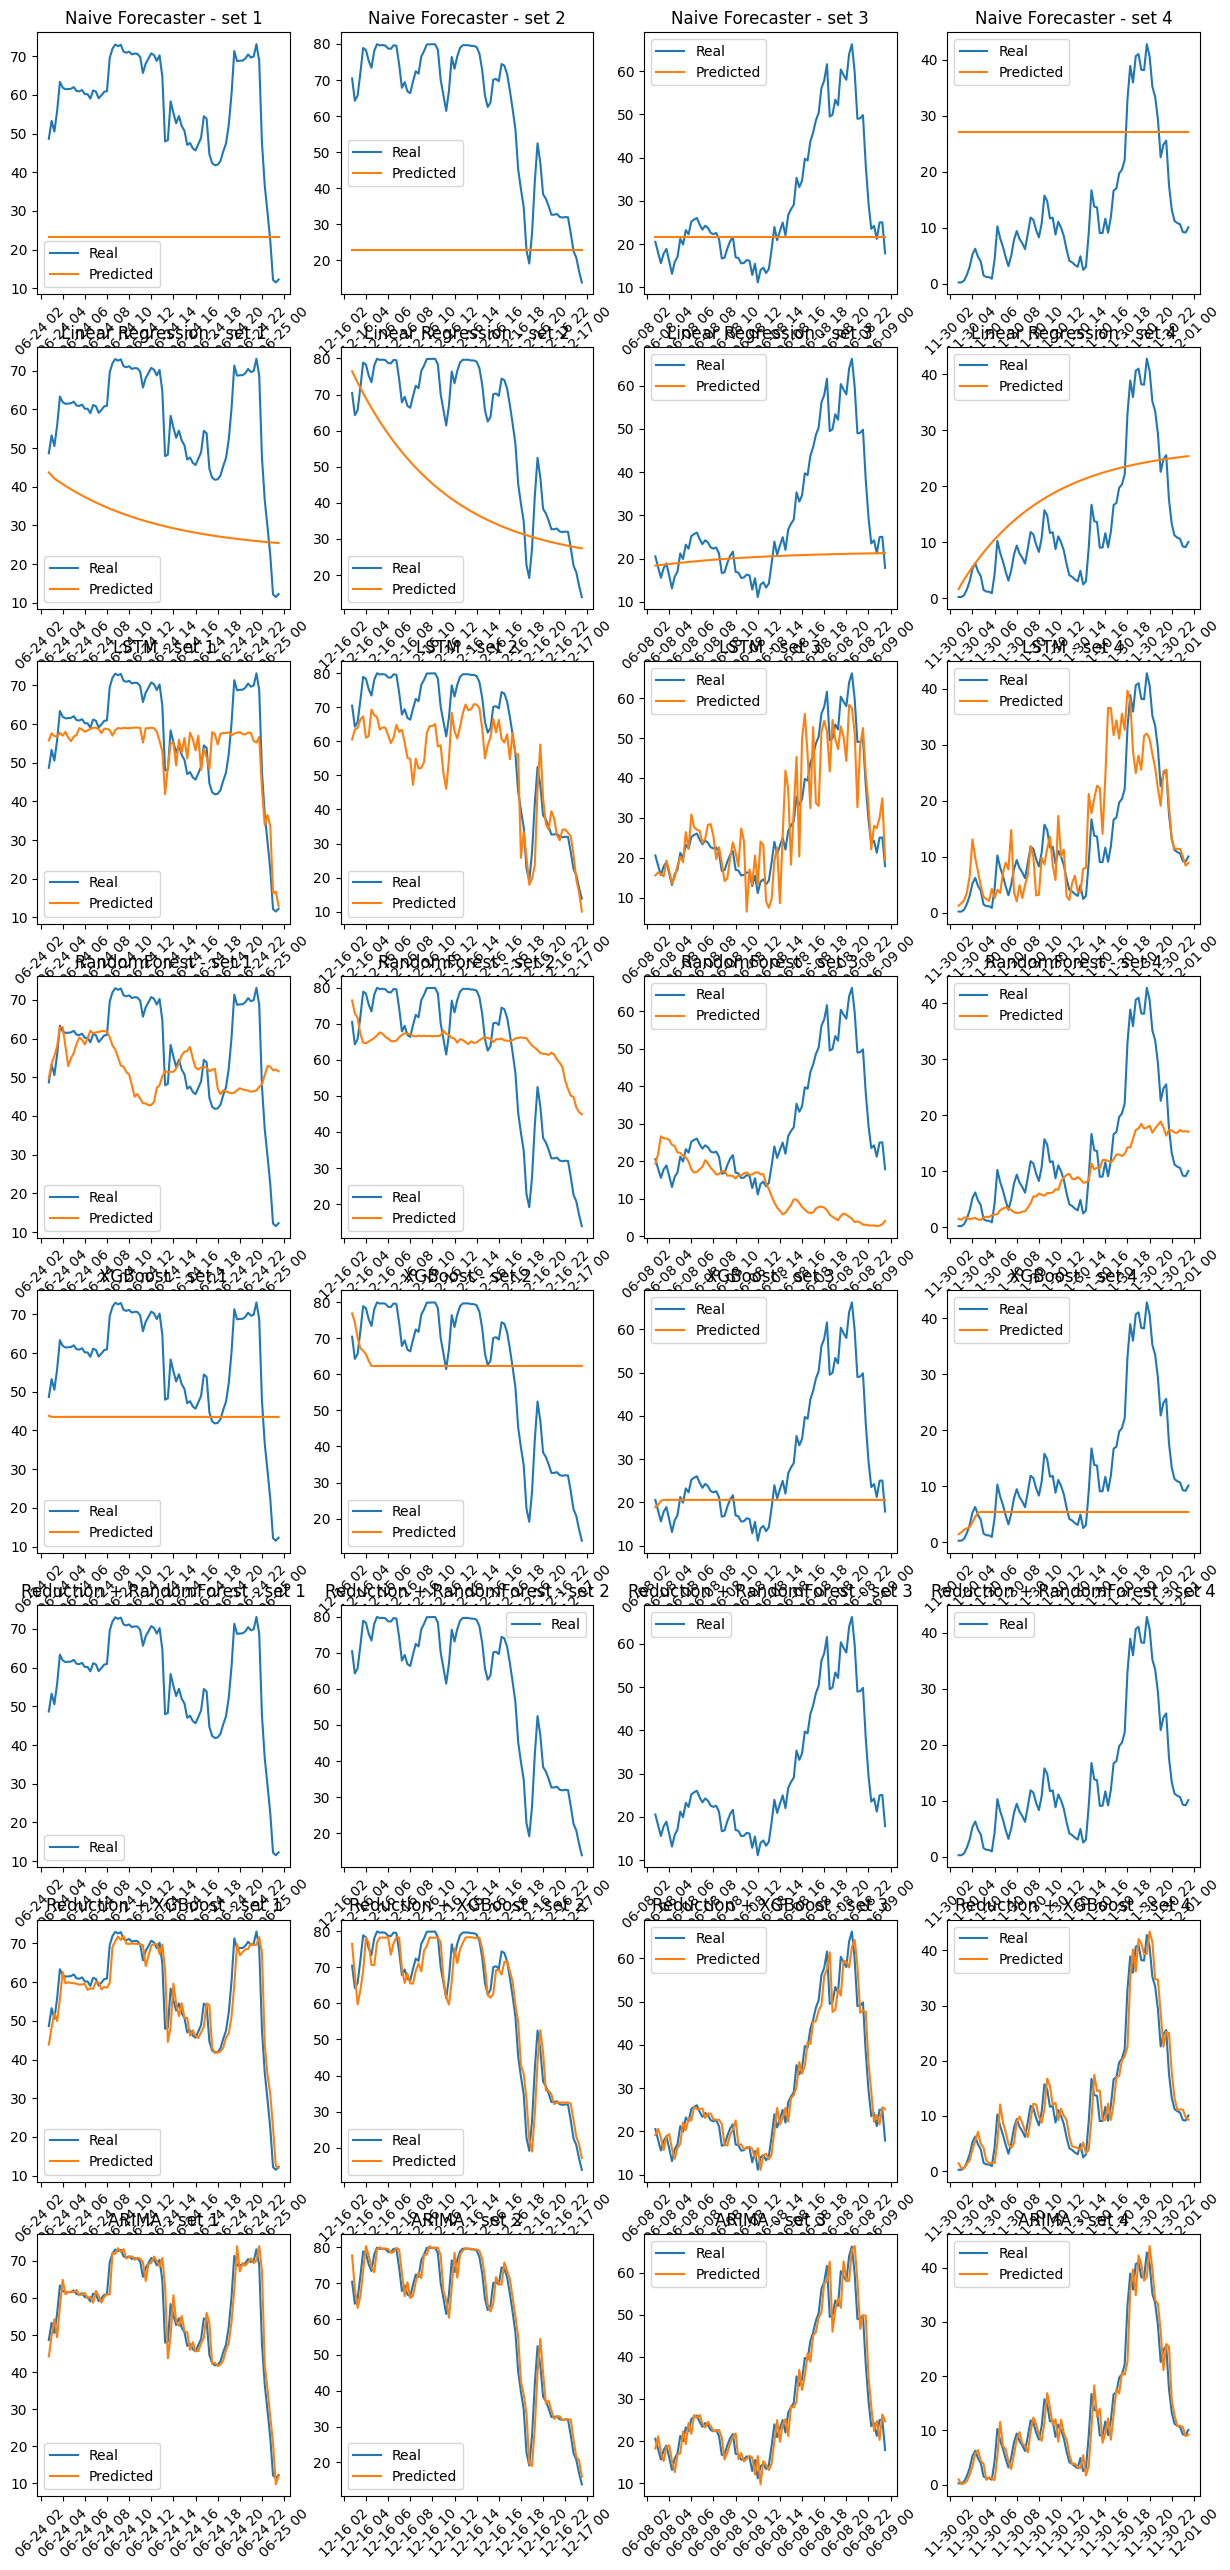

In [ ]:
plt.figure(figsize=(15, 32))  # Increase the height to accommodate one more row

# Plot Naive Forecaster
plt.subplot(8, 4, 1)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_naive_1, label='Predicted')
plt.title('Naive Forecaster - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 2)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_naive_2, label='Predicted')
plt.title('Naive Forecaster - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 3)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_naive_3, label='Predicted')
plt.title('Naive Forecaster - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 4)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_naive_4, label='Predicted')
plt.title('Naive Forecaster - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot Linear Regression
plt.subplot(8, 4, 5)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_linear_1, label='Predicted')
plt.title('Linear Regression - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 6)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_linear_2, label='Predicted')
plt.title('Linear Regression - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 7)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_linear_3, label='Predicted')
plt.title('Linear Regression - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 8)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_linear_4, label='Predicted')
plt.title('Linear Regression - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot LSTM
plt.subplot(8, 4, 9)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_lstm_1, label='Predicted')
plt.title('LSTM - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 10)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_lstm_2, label='Predicted')
plt.title('LSTM - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 11)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_lstm_3, label='Predicted')
plt.title('LSTM - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 12)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_lstm_4, label='Predicted')
plt.title('LSTM - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot RandomForest
plt.subplot(8, 4, 13)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_randomforest_1, label='Predicted')
plt.title('RandomForest - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 14)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_randomforest_2, label='Predicted')
plt.title('RandomForest - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 15)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_randomforest_3, label='Predicted')
plt.title('RandomForest - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 16)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_randomforest_4, label='Predicted')
plt.title('RandomForest - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot XGBoost
plt.subplot(8, 4, 17)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_xgboost_1, label='Predicted')
plt.title('XGBoost - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 18)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_xgboost_2, label='Predicted')
plt.title('XGBoost - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 19)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_xgboost_3, label='Predicted')
plt.title('XGBoost - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 20)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_xgboost_4, label='Predicted')
plt.title('XGBoost - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot Reduction + XGBoost
plt.subplot(8, 4, 25)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_reduction_xgboost_1, label='Predicted')
plt.title('Reduction + XGBoost - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 26)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_reduction_xgboost_2, label='Predicted')
plt.title('Reduction + XGBoost - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 27)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_reduction_xgboost_3, label='Predicted')
plt.title('Reduction + XGBoost - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 28)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_reduction_xgboost_4, label='Predicted')
plt.title('Reduction + XGBoost - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot ARIMA
plt.subplot(8, 4, 29)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_arima_1, label='Predicted')
plt.title('ARIMA - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 30)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_arima_2, label='Predicted')
plt.title('ARIMA - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 31)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_arima_3, label='Predicted')
plt.title('ARIMA - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 32)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_arima_4, label='Predicted')
plt.title('ARIMA - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot SARIMA
plt.subplot(8, 4, 33)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_sarima_1, label='Predicted')
plt.title('SARIMA - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 34)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_sarima_2, label='Predicted')
plt.title('SARIMA - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 35)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_sarima_3, label='Predicted')
plt.title('SARIMA - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(8, 4, 36)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_sarima_4, label='Predicted')
plt.title('SARIMA - set 4')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## **Testing the best models for the demo dataset**

MAE for df_demo: 4.169190442406191


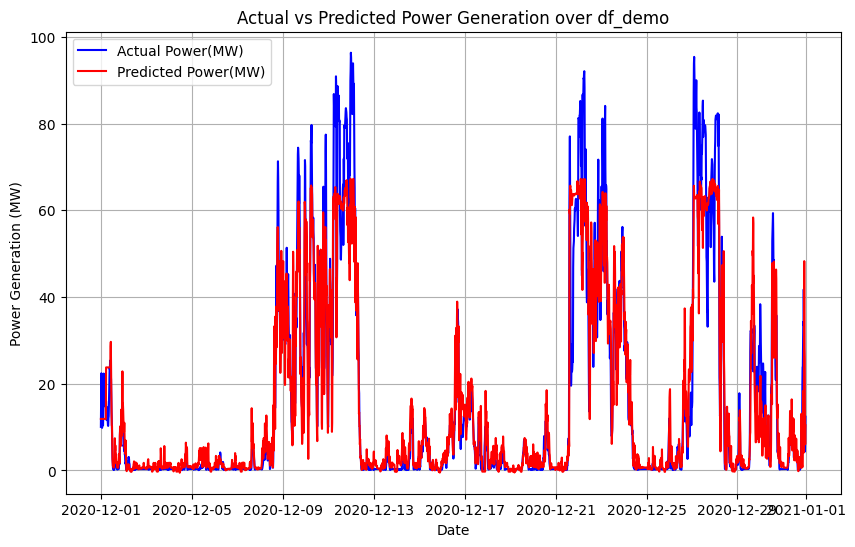

In [ ]:
# Select relevant features for prediction
features_demo = df_demo[features_to_test]

# Train the XGBoost model on the full df_wf1_model dataset
# Train the XGBoost model on the full df_wf1_model dataset using only the selected features
xgboost_model_full = xgb.XGBRegressor(max_depth=3, learning_rate=0.11, n_estimators=62)
xgboost_model_full.fit(df_wf1_model[features_to_test], df_wf1_model['Power(MW)'])


# Predict for the df_demo dataset
predictions_demo = xgboost_model_full.predict(features_demo)

# Create a copy of df_demo to avoid the SettingWithCopyWarning
df_demo_copy = df_demo.copy()
df_demo_copy['Predicted Power(MW)'] = predictions_demo

# Calculate MAE for df_demo
mae_demo = mean_absolute_error(df_demo_copy['Power(MW)'], df_demo_copy['Predicted Power(MW)'])
print(f"MAE for df_demo: {mae_demo}")

# Plot the predicted and actual power generation values over df_demo
plt.figure(figsize=(10, 6))
plt.plot(df_demo_copy.index, df_demo_copy['Power(MW)'], label='Actual Power(MW)', color='blue')
plt.plot(df_demo_copy.index, df_demo_copy['Predicted Power(MW)'], label='Predicted Power(MW)', color='red')
plt.xlabel('Date')
plt.ylabel('Power Generation (MW)')
plt.title('Actual vs Predicted Power Generation over df_demo')
plt.legend()
plt.grid(True)
plt.show()



## **Backtesting**

In [ ]:
#model_lstm.update(df_wf1_test)